In [1]:
%cd ..

/home/marco/contrast-gan-3D


In [3]:
import os

# https://discuss.pytorch.org/t/gpu-device-ordering/60785/2
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import numpy as np

from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.experiments.basic_conf import *
from contrast_gan_3D.experiments.test_conf_2D import *
# from contrast_gan_3D.experiments.gradient_penalty_conf import *
from contrast_gan_3D.model.loss import HULoss
from contrast_gan_3D.trainer.Trainer import Trainer
from contrast_gan_3D.trainer.utils import create_dataloaders, cval_paths
from contrast_gan_3D.utils import set_GPU

In [3]:
profiler_dir = None
run_id = "pippo"
fold_idx = 0

train_folds, val_folds = cval_paths(n_cval_folds, "/home/marco/data/ostia_final.xlsx")

scaled_HU_bounds = scaler(np.array(desired_HU_bounds))
print(scaled_HU_bounds)

train_loaders, val_loaders = create_dataloaders(
    train_folds[fold_idx],
    val_folds[fold_idx],
    train_patch_size,
    val_patch_size,
    train_batch_size,
    val_batch_size,
    rng,
    scaler,
    train_transform=train_transform,
)

[0.18666667 0.35333333]


In [4]:
from contrast_gan_3D.trainer.logger.LoggerInterface import SingleThreadedLogger

logger_interface = SingleThreadedLogger(logger_interface.logger)

chosen_bs = train_batch_size
chosen_ps = train_patch_size
chosen_loaders = train_loaders

# logger_interface.logger.sample_size = chosen_ps[ScanType.OPT.value]

subopt_bs = (
    chosen_bs[ScanType.LOW.value] + chosen_bs[ScanType.HIGH.value],
    1,
    *chosen_ps,
)
opt_bs = (chosen_bs[ScanType.OPT.value], 1, *chosen_ps)
print(subopt_bs, opt_bs)

(32, 1, 128, 128) (32, 1, 128, 128)


In [5]:
device = set_GPU(3)

trainer = Trainer(
    train_iterations,
    val_iterations,
    validate_every,
    train_generator_every,
    log_every,
    log_images_every,
    generator_class,
    critic_class,
    generator_optim_class,
    critic_optim_class,
    HULoss(*scaled_HU_bounds, subopt_bs),
    # HULoss(*scaled_HU_bounds, (train_batch_size * 2, 1, *train_patch_size)),
    logger_interface,
    val_batch_size,
    weight_clip=weight_clip,
    generator_lr_scheduler_class=generator_lr_scheduler_class,
    critic_lr_scheduler_class=critic_lr_scheduler_class,
    device=device,
    checkpoint_every=checkpoint_every,
    rng=rng,
)
# trainer.load_checkpoint(
#     # "/home/marco/contrast-gan-3D/logs/model_checkpoints/9hnh7gto.pt"
#     "/home/marco/contrast-gan-3D/logs/model_checkpoints/07qiygyk.pt"
# )

[2024-04-23 17:18:24,484: INFO] Using device: cuda:3 (contrast_gan_3D.trainer.Trainer:80)


In [6]:
from contrast_gan_3D.model import utils as model_utils

print(model_utils.count_parameters(trainer.critic))
print(model_utils.count_parameters(trainer.generator))

174801
491873


In [7]:
print(trainer.critic)
print("-----------")
print(trainer.generator)

PatchGANDiscriminator(
  (model): Sequential(
    (first): ConvBlock(
      (conv): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (normalization): Identity()
      (activation_fn): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (middle): Sequential(
      (0): ConvBlock(
        (conv): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (normalization): Identity()
        (activation_fn): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (normalization): Identity()
        (activation_fn): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): ConvBlock(
        (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (normalization): Identity()
        (activation_fn): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (last): Conv3d(64, 1, k

In [8]:
patches = [next(chosen_loaders[scan_type.value]) for scan_type in ScanType]
[p["data"].shape for p in patches]

using pin_memory on device 3
using pin_memory on device 3
using pin_memory on device 3


[torch.Size([6, 1, 128, 128, 128]),
 torch.Size([3, 1, 128, 128, 128]),
 torch.Size([3, 1, 128, 128, 128])]

{'step': 0,
 'train/D': tensor(5.0261, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/D-fake': tensor(-0.0111, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/D-real': tensor(-0.0112, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/G': tensor(0.0097, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/G-full': tensor(-0.8194, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/HU': tensor(0.1002, device='cuda:3', grad_fn=<MeanBackward0>),
 'train/sim': tensor(-0.9293, device='cuda:3', grad_fn=<MeanBackward0>)}


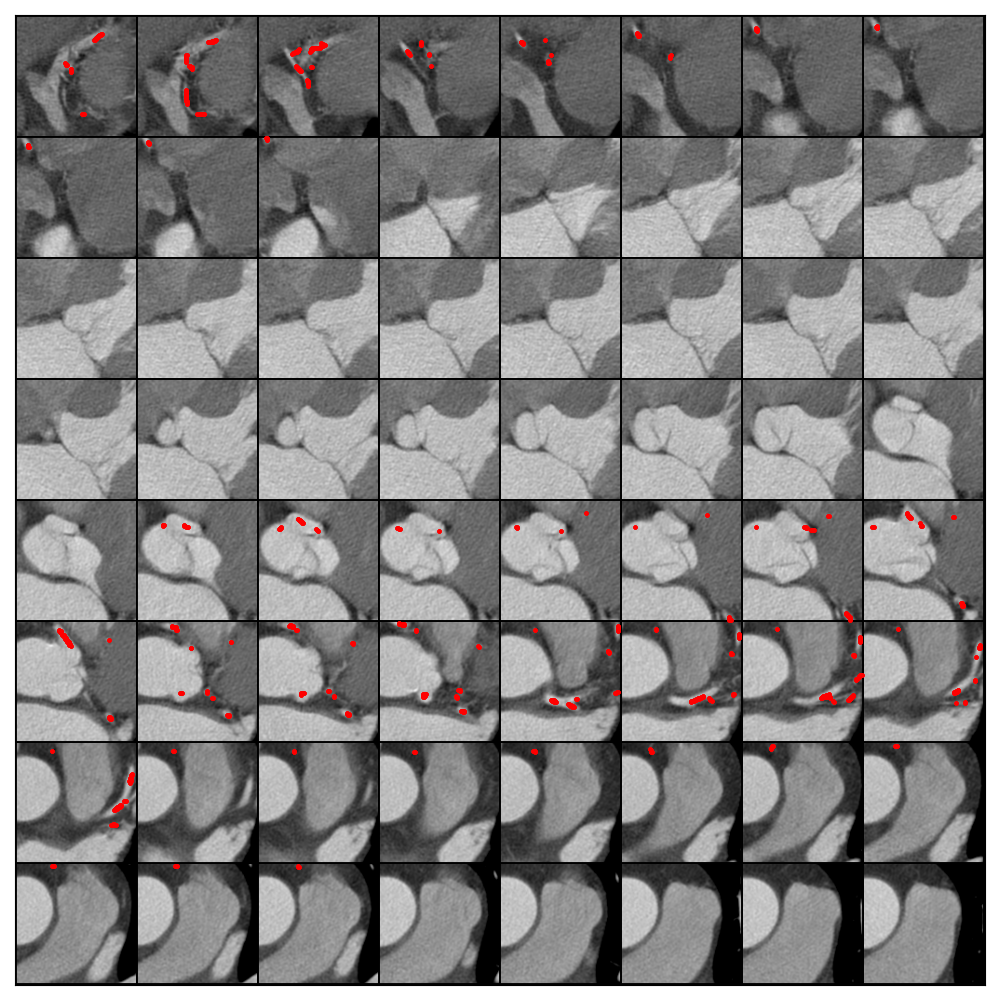

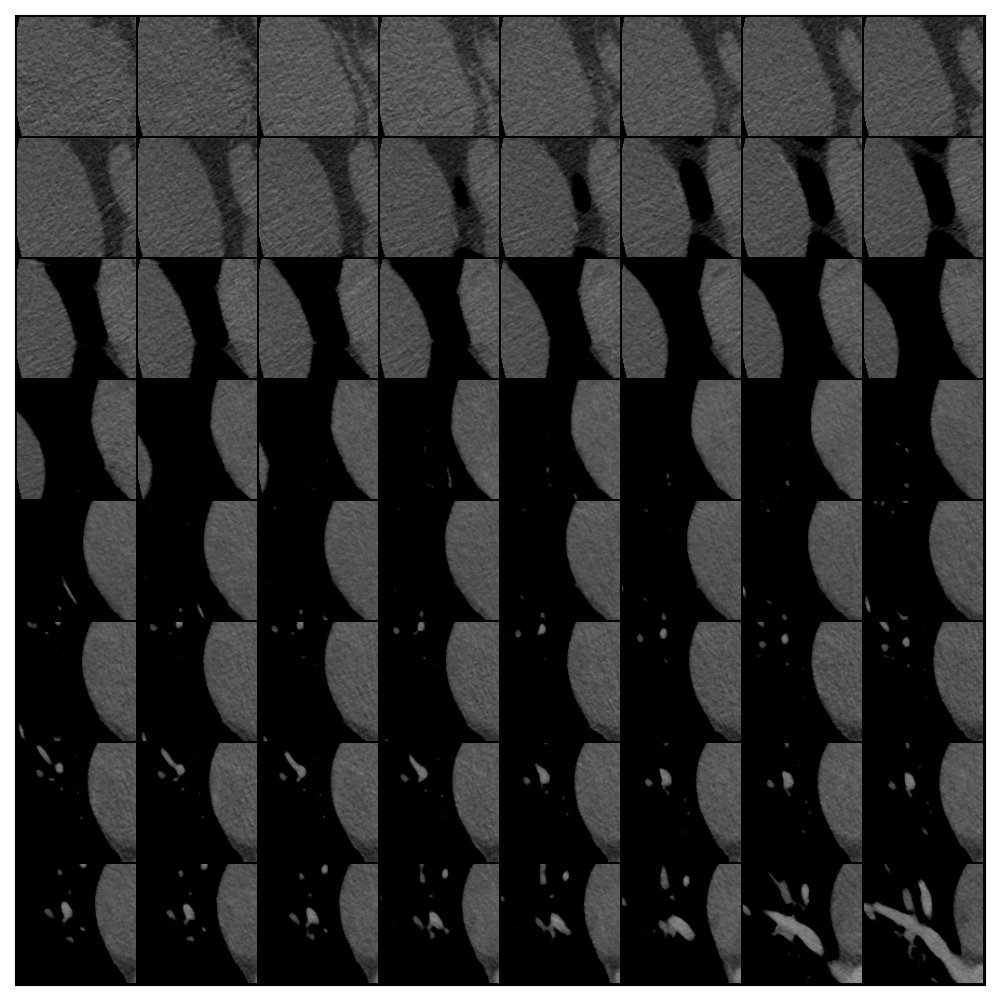

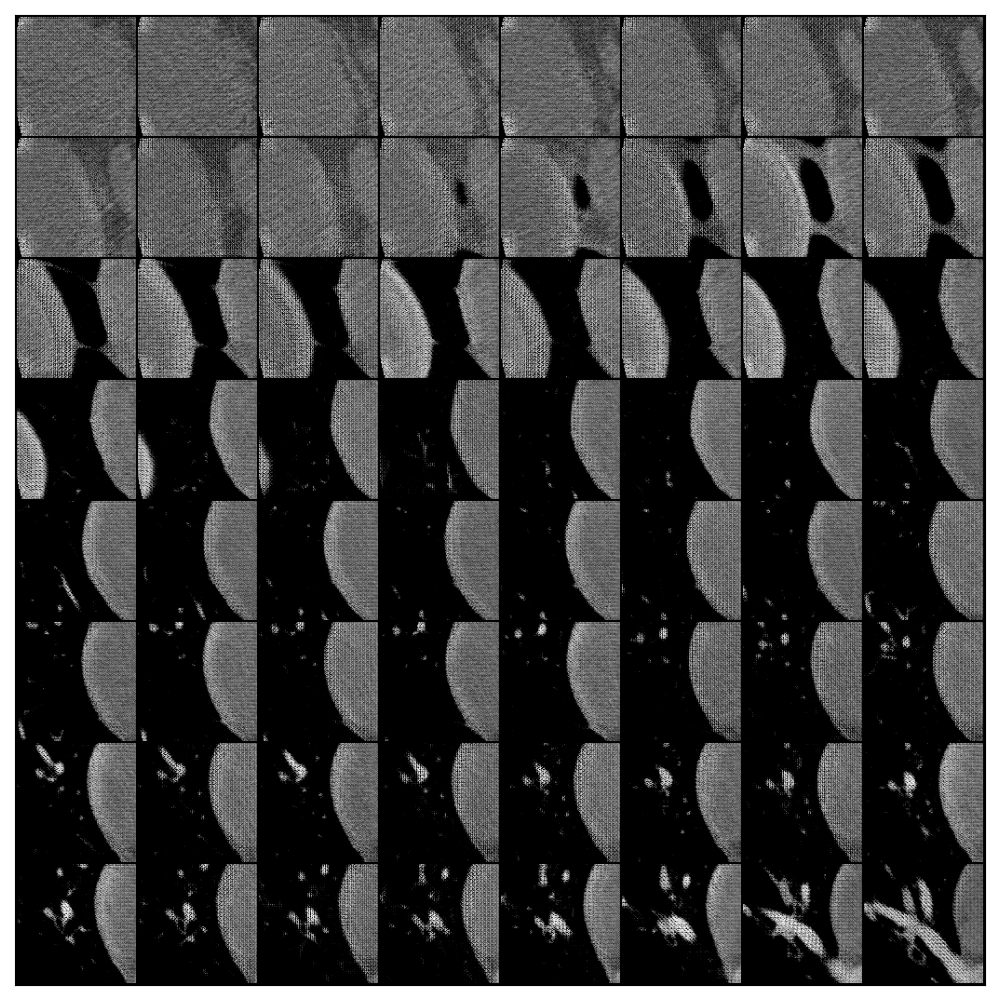

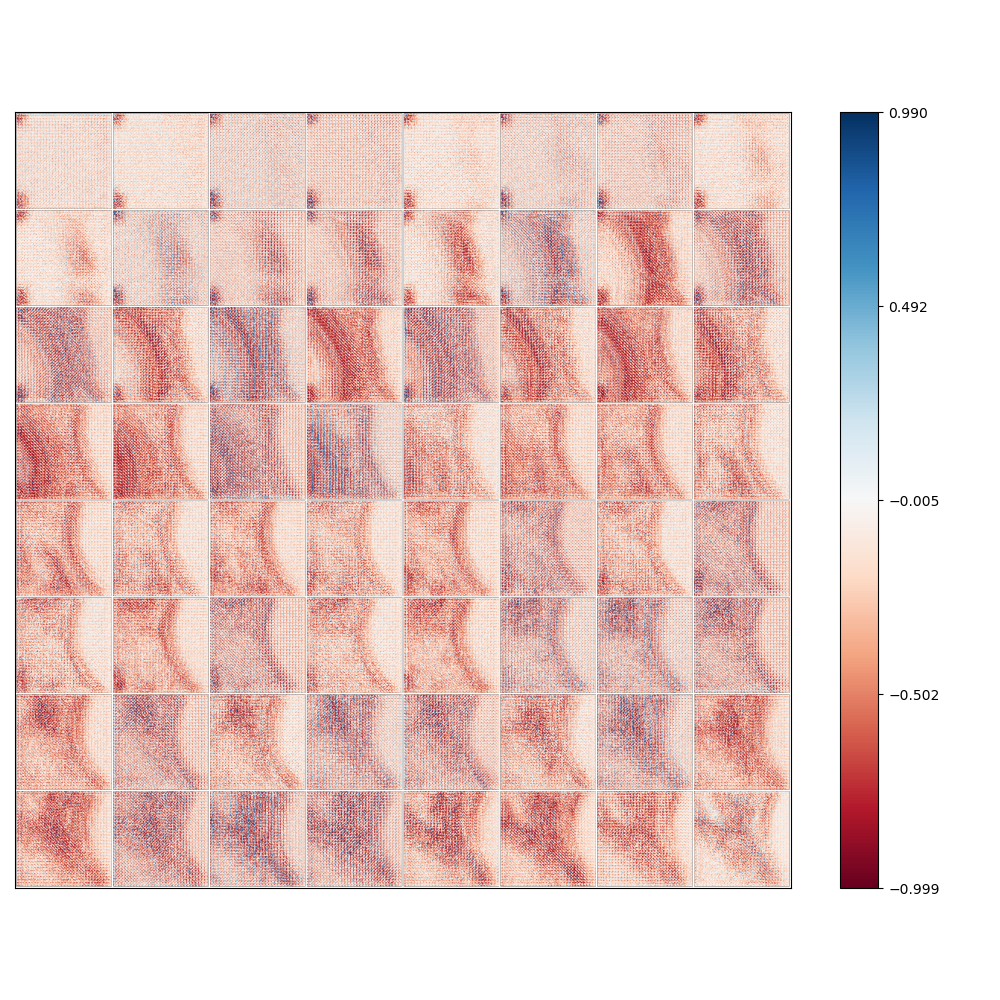

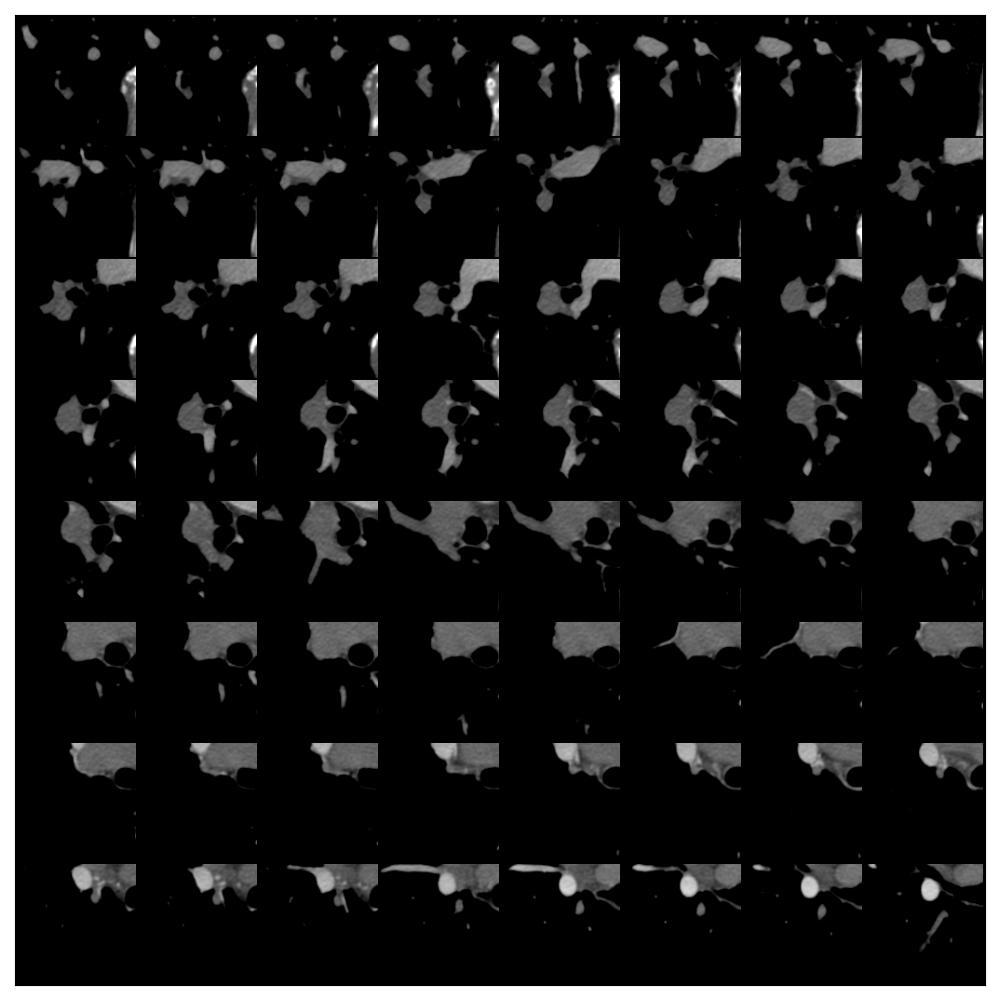

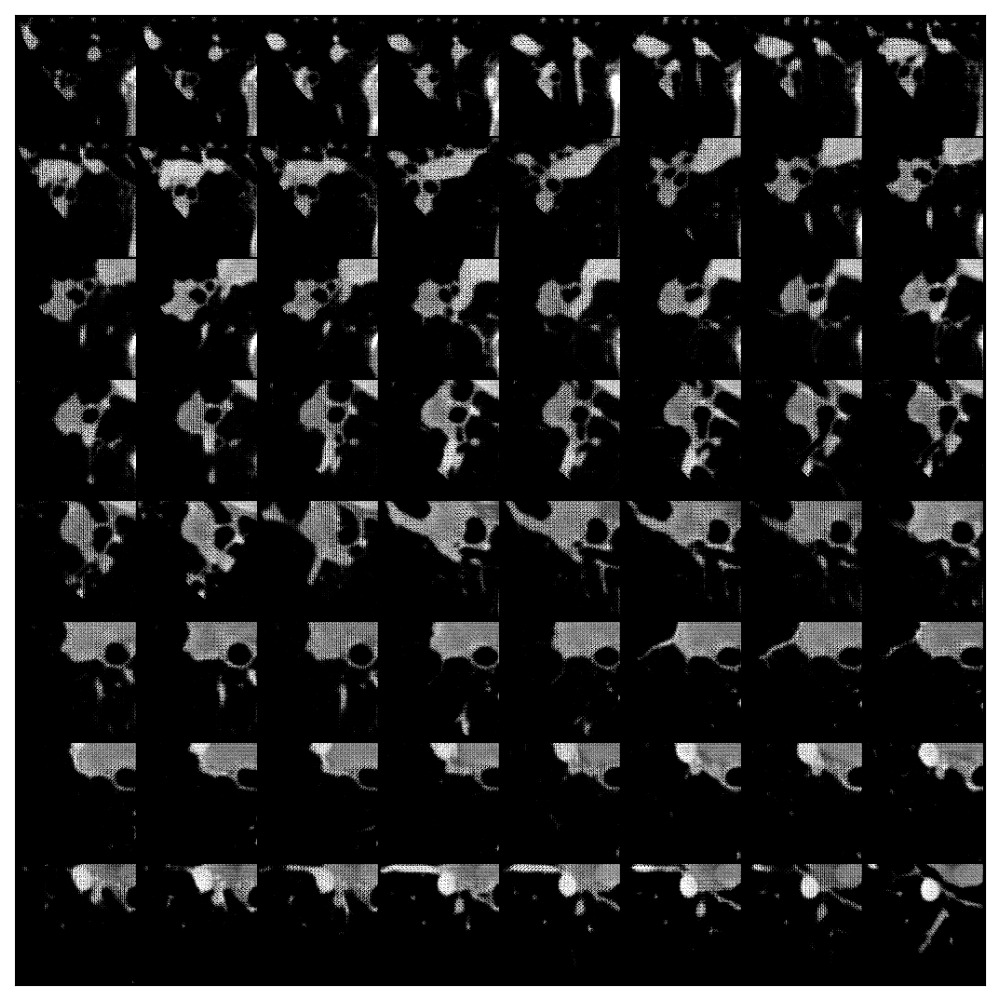

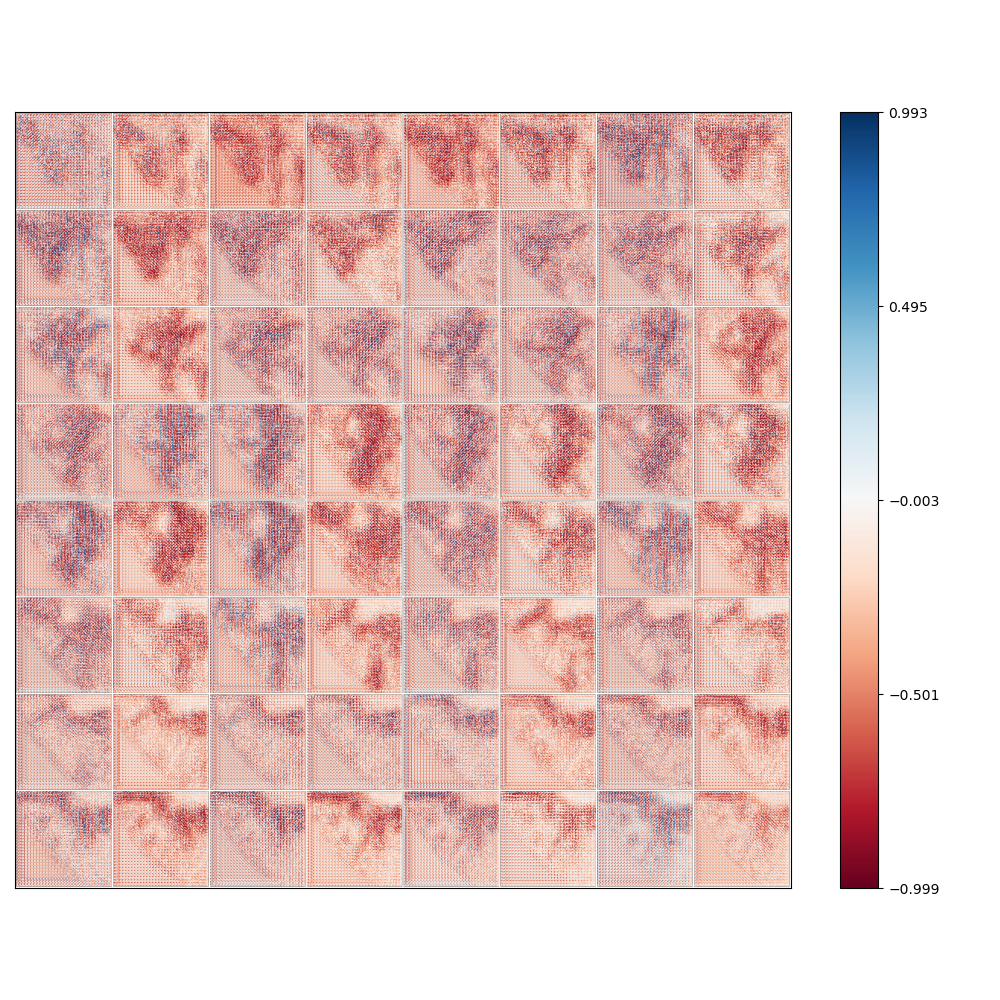

In [9]:
trainer.train_step(patches, 0)

In [11]:
model_utils.compute_convolution_filters_shape(trainer.critic, patches[0]["data"].shape[1:], show=True)
print("----")
model_utils.compute_convolution_filters_shape(trainer.generator, patches[0]["data"].shape[1:], show=True)

Input shape: [1, 512, 512]
model.first.conv                         -> [16, 256, 256]         # params: 272        weight: [16, 1, 4, 4]        bias: [16]
model.middle.0.conv                      -> [32, 128, 128]         # params: 8192       weight: [32, 16, 4, 4]      
model.middle.1.conv                      -> [64, 64, 64]           # params: 32768      weight: [64, 32, 4, 4]      
model.middle.2.conv                      -> [128, 32, 32]          # params: 131072     weight: [128, 64, 4, 4]     
model.last                               -> [1, 31, 31]            # params: 2049       weight: [1, 128, 4, 4]       bias: [1]
----
Input shape: [1, 512, 512]
model.first.conv                         -> [16, 512, 512]         # params: 784        weight: [16, 1, 7, 7]       
model.downsampling.0.conv                -> [32, 256, 256]         # params: 4608       weight: [32, 16, 3, 3]      
model.downsampling.1.conv                -> [64, 128, 128]         # params: 18432      weight: [64, 

[1, 128, 128]

In [ ]:
attenuations = trainer.generator(subopt)
recon = subopt - attenuations

print(attenuations[1].min(), attenuations[1].max())

D_real  = trainer.critic(opt)
D_fake = trainer.critic(recon.detach())

tensor(-0.9183, device='cuda:3', grad_fn=<MinBackward1>) tensor(0.9989, device='cuda:3', grad_fn=<MaxBackward1>)


In [ ]:
from torchviz import make_dot

from contrast_gan_3D.model.utils import wgan_gradient_penalty

loss_D = trainer.loss_GAN(D_fake, D_real)
gp = wgan_gradient_penalty(
    opt.repeat((2,) + (1,) * len(opt.shape[1:])),
    recon,
    trainer.critic,
    trainer.device,
)
if False:
    loss_D += gp


# loss_D.backward()

loss_G = -trainer.loss_GAN(trainer.critic(recon))
# loss_G.backward()

In [ ]:
make_dot(gp)

In [ ]:
from matplotlib import pyplot as plt

from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.data.HD5Scan import HD5Scan

centerlines_pixels = {k: np.array([]) for k in ScanType}
for sc in centerlines_pixels:
    print(sc)
    arr = centerlines_pixels[sc]
    val_load = val_loaders[sc.value]
    for p in val_load.generator._data:
        print(p)
        with HD5Scan(p) as scan:
            arr = np.append(arr, scan.ccta[scan.labelmap[::].astype(bool)])
    centerlines_pixels[sc] = arr


[len(c) for c in centerlines_pixels.values()]

In [ ]:
fig, ax = plt.subplots()

for sc, v in centerlines_pixels.items():
    ax.hist(v, bins=80, alpha=0.5, density=True, label=sc.name)
fig.legend()
fig.suptitle("Arteries centerlines HU distribution")
fig.tight_layout()
plt.show()
plt.close(fig)

In [ ]:
from pathlib import Path
from typing import List


# NOTE need some form of patch aggregation
def compute_histograms(paths: List[Path]):
    ...

def plot_histograms():
    ...

In [ ]:
from torch import nn

# idea of 1D convolution: bottleneck!
inp_shape = (256, 128, 128, 128)
model_utils.print_convolution_filters_shape(nn.Conv3d(256, 64, 1, 1, 0), inp_shape)
model_utils.print_convolution_filters_shape(nn.Conv3d(64, 64, 3, 1, 1), inp_shape)
model_utils.print_convolution_filters_shape(nn.Conv3d(64, 256, 1, 1, 0), inp_shape)
print('------')
model_utils.print_convolution_filters_shape(nn.Conv3d(256, 256, 3, 1, 1), inp_shape)

In [ ]:
# EXAMPLE TO CREATE SITK IMAGES TO IMPORT INTO ITK-SNAP
from pathlib import Path

from contrast_gan_3D.data.HD5Scan import HD5Scan
from contrast_gan_3D.utils import io_utils

test_folder = Path("/home/marco/data/after_preproc")
test_folder.mkdir(exist_ok=True)

p = Path("/home/marco/data/MMWHS/ct_test/ct_test_2035_image.h5")
print(p)

if False:
    with HD5Scan(p) as scan:
        pprint(scan.meta)
        print(scan.ccta.shape)

        # HWD -> DHW (xyz->zyx, numpy to sitk convention)
        ccta = scan.ccta[::].transpose(2, 0, 1)
        io_utils.to_itksnap_volume(
            ccta,
            scan.meta["offset"],
            scan.meta["spacing"],
            test_folder / f"{p.stem}.mhd",
        )